# Batch Coactivity Analysis

## Notebook for preprocessing and analyzing coactivity spine data

In [1]:
import os
import numpy as np
from Lab_Analyses.Spine_Analysis.preprocess_spine_data import organize_dual_spine_data
from Lab_Analyses.Spine_Analysis.grouped_coactivity_analysis import grouped_coactivity_analysis
from Lab_Analyses.Spine_Analysis.coactivity_plasticity_analysis import Coactivity_Plasticity
from Lab_Analyses.Utilities.save_load_pickle import load_pickle

### Datasets
Specify mice which mice to be processed and analyzed

In [2]:
# Mouse ids
id_1 = "JW082"
id_2 = "JW083"
id_3 = "JW090"
id_4 = "JW092"
id_5 = "JW126"
id_6 = "JW129"
id_7 = "JW130"

mouse_list = [id_1, id_2, id_3, id_4, id_5, id_6, id_7]
#mouse_list = [id_4, id_6]

### Preprocessing
Preprocess spine datasets

In [ ]:
# Do you want to reprocess the data
reprocess = False
channels = {"GluSnFr": "GreenCh", "Calcium": "RedCh"}
fov_type = "apical"

# Process data
if reprocess:
    for mouse in mouse_list:
        organize_dual_spine_data(mouse, channels, fov_type=fov_type, redetection=True, save=True, structural=True)

### Grouped Coactivity Analysis
Perform coactivity analysis across all mice and FOVs for a given set of imaging sessions

In [ ]:
# Set up parameters
## Save path
group_path = r'C:\Users\Jake\Desktop\Analyzed_data\grouped'
experiment_dir = "Dual_Spine_Imaging"
coactivity_dir = "Coactivity_Data"
coactivity_path = os.path.join(group_path, experiment_dir, coactivity_dir)

## Analysis parameters
reanalyze = True
save = True
days = ["Early", "Middle", "Late"]
#days = ["Middle"]
followup = True
zscore = False
volume_norm = True
fov_type = "apical"

coactivity_data = {}
for day in days:
    print(f"-{day}")
    coactivity = grouped_coactivity_analysis(
        mouse_list,
        day,
        followup=followup,
        fov_type=fov_type,
        activity_window=(-2,4),
        zscore=zscore,
        volume_norm=volume_norm,
        save=save,
        save_path=coactivity_path,
    )

    coactivity_data[day] = coactivity

In [3]:
group_path = r'C:\Users\Jake\Desktop\Analyzed_data\grouped'
experiment_dir = "Dual_Spine_Imaging"
coactivity_dir = "Coactivity_Data"
coactivity_path = os.path.join(group_path, experiment_dir, coactivity_dir)

load_coactivity = True
if load_coactivity:
    names = ["Early_dFoF_norm_spine_coactivity_data", "Middle_dFoF_norm_spine_coactivity_data", "Late_dFoF_norm_spine_coactivity_data"]
    data = load_pickle(names, coactivity_path)
    days = ["Early", "Middle", "Late"]
    coactivity_data = dict(zip(days, data))

### Coactivity Plasticity Analysis
Perform analysis to relate subsequent plasticity to coactivity 

In [4]:
## Save path
group_path = r'C:\Users\Jake\Desktop\Analyzed_data\grouped'
experiment_dir = "Dual_Spine_Imaging"
plasticity_dir = "Coactivity_Plasticity"
plasticity_path = os.path.join(group_path, experiment_dir, plasticity_dir)

In [5]:

## Analysis parameters
threshold = 0.5
exclude = "Shaft Spine"
save = True

plasticity_data = {}
for key, value in coactivity_data.items():
    plasticity = Coactivity_Plasticity(
        value, threshold, exclude, vol_norm=False, save=save, save_path=plasticity_path
    )
    plasticity_data[key] = plasticity

### Visualize Coactivity Plasticity Data
Plot selected data and variables from individual datasets.
Use data generated above of load in a dataset

In [6]:
# Select data to plot
load_data = False
initial_path = r"C:\Users\Jake\Desktop\Figures\grouped_data"
figure_path = os.path.join(initial_path, experiment_dir, plasticity_dir, "Early")
if not os.path.isdir(figure_path):
    os.makedirs(figure_path)
if load_data:
    load_name = "Early_dFoF_norm_0.5_coactivity_plasticity_data"
    plot_data = load_pickle([load_name], plasticity_path)[0]
else:
    plot_data = plasticity_data["Early"]


In [7]:
# Print out variable names
for key in plot_data.__dict__.keys():
    print(key)

day
threshold
exclude
vol_norm
parameters
save
save_path
group_dict
relative_volumes
enlarged_spines
shrunken_spines
stable_spines
mouse_id
FOV
dendrite_length
spine_flags
followup_flags
spine_volumes
spine_volumes_um
followup_volumes
followup_volumes_um
movement_spines
nonmovement_spines
rwd_movement_spines
rwd_nonmovement_spines
movement_dendrites
nonmovement_dendrites
rwd_movement_dendrites
rwd_nonmovement_dendrites
spine_activity_rate
dend_activity_rate
distance_activity_rate
ind_distance_activity_rate
distance_relative_activity_rate
ind_distance_relative_activity_rate
distance_coactivity_rate
ind_distance_coactivity_rate
distance_correlation
ind_distance_correlation
distance_coactivity_rate_norm
ind_distance_coactivity_rate_norm
MRS_distance_coactivity_rate
MRS_distance_coactivity_rate_norm
nMRS_distance_coactivity_rate
nMRS_distance_coactivity_rate_norm
movement_distance_coactivity_rate
movement_distance_coactivity_rate_norm
nonmovement_distance_coactivity_rate
nonmovement_distan

In [ ]:
print(sum(plot_data.enlarged_spines))
print(sum(plot_data.shrunken_spines))
print(sum(plot_data.stable_spines))

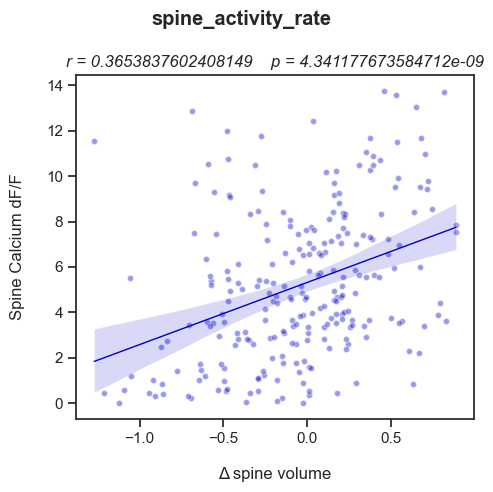

In [14]:
# Correlation Plots
plot_data.plot_volume_correlation(
    variable_name="spine_activity_rate",
    volume_type="relative_volume",
    CI=95,
    ytitle="Spine Calcium dF/F",
    xlim=None,
    ylim=None,
    face_color="mediumblue",
    edge_color="white",
    edge_width=1,
    s_size=20,
    s_alpha=0.4,
    line_color="mediumblue",
    line_width=1,
    log_trans=True,
    save=False,
    save_path=figure_path
)

In [ ]:
# Group mean activity plots
plot_data.plot_group_scatter_plot(
    variable_name="conj_spine_coactive_calcium",
    group_type="plastic_spines",
    mean_type="mean",
    err_type="sem",
    figsize=(3,4),
    ytitle="Relative Coactivity Rate",
    ylim=None,
    s_colors=["darkorange", "forestgreen", "silver"],
    s_size=5,
    s_alpha=0.7,
    b_colors=["darkorange", "forestgreen", "silver"],
    b_edgecolors = "black",
    b_err_colors="black",
    b_width=0.7,
    b_linewidth=0,
    b_alpha=0.3,
    test_type="nonparametric",
    test_method="holm-sidak",
    save=False,
    save_path=figure_path,
)

In [ ]:

plot_data.plot_multi_group_scatter_plots(
    variable_name="conj_spine_coactive_calcium",
    group_type="movement_spines",
    subgroup_type="plastic_spines",
    mean_type="mean",
    err_type="sem",
    figsize=(7,4),
    ytitle="Fraction of Dendritic Events",
    ylim=None,
    s_colors=["darkorange", "forestgreen", "silver"],
    s_alpha=0.8,
    s_size=5,
    b_colors=["darkorange", "forestgreen", "silver"],
    b_edgecolors="black",
    b_err_colors="black",
    b_width=0.2,
    b_linewidth=0,
    b_alpha=0.3,
    test_method="sidak",
    save=False,
    save_path=figure_path,
)

In [ ]:
plot_data.plot_group_spine_mean_traces(
    group_type="plastic_spines",
    trace_type="conj_spine_coactive_calcium_traces",
    exclude=[],
    avlines=(30,90),
    ahlines=[0.10,0.11,0.12],
    figsize=(7.5,5),
    colors=["darkorange", "forestgreen", "silver"], 
    ylim=(0, 0.15),
    test_method="fdr_bh",
    save=False,
    save_path=figure_path
)

enlarged_spines: r = -0.2439923406694606    p-val = 2.5450086057575507e-08
shrunken_spines: r = -0.09580440371140675    p-val = 0.0424512226705417
stable_spines: r = -0.1478495775550533    p-val = 0.00018265377648988738
╒═════════════╤══════════╤═══════╤═══════╤══════════╤═════════╤═════════════╤═══════════════╤═══════════╤════════════╤══════════════╤════════════╤═══════════════╕
│ Source      │       SS │   DF1 │   DF2 │       MS │       F │       p-unc │     p-GG-corr │       np2 │        eps │   sphericity │    W-spher │       p-spher │
╞═════════════╪══════════╪═══════╪═══════╪══════════╪═════════╪═════════════╪═══════════════╪═══════════╪════════════╪══════════════╪════════════╪═══════════════╡
│ group       │ 18.0448  │     2 │   104 │ 9.02238  │ 2.87843 │ 0.0607136   │ nan           │ 0.0524511 │ nan        │          nan │ nan        │ nan           │
├─────────────┼──────────┼───────┼───────┼──────────┼─────────┼─────────────┼───────────────┼───────────┼────────────┼──────────

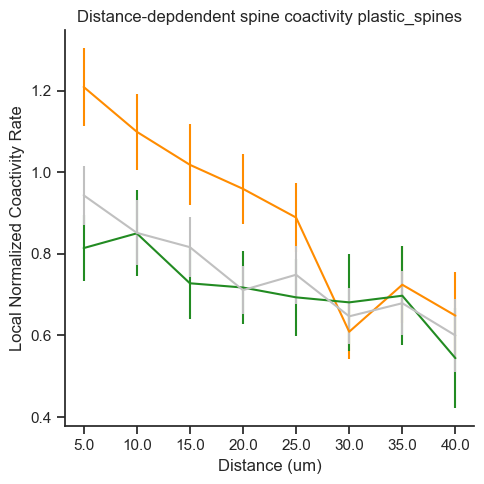

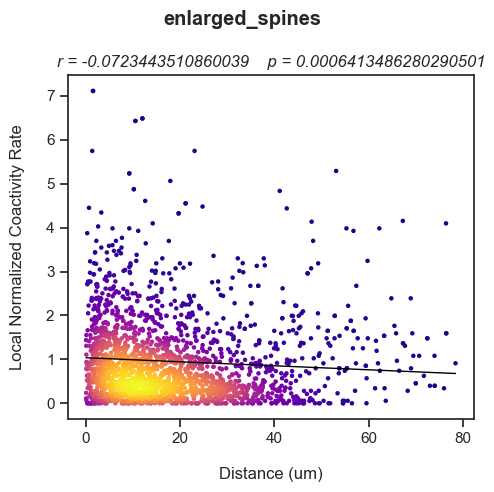

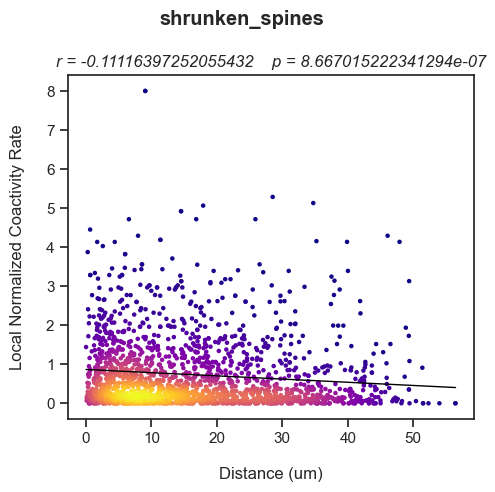

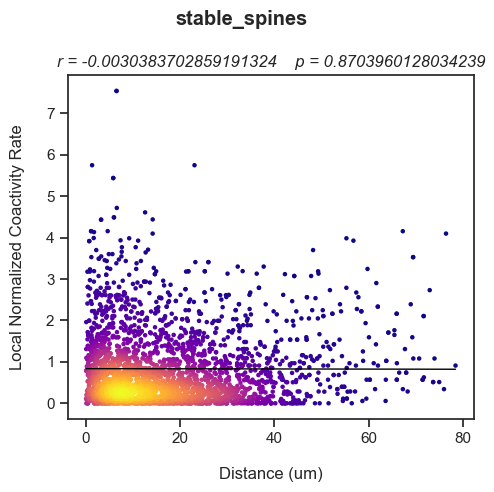

In [8]:
plot_data.plot_spine_coactivity_distance(
    variable_name="distance_coactivity_rate",
    group_type="plastic_spines",
    figsize=(5,5),
    colors=["darkorange", "forestgreen", "silver"],
    ylim=None,
    ytitle="Local Normalized Coactivity Rate",
    test_method="holm-sidak",
    save=False,
    save_path=figure_path,
)

In [ ]:
plot_data.plot_histogram(
    variable="conj_relative_onset",
    bins=50,
    max_lim=None,
    avlines=(0,0),
    figsize=(5,5),
    color="blue",
    alpha=0.4,
    save=False,
    save_path=figure_path
)

In [ ]:
plot_data.plot_group_mean_heatmaps(
    trace_type="conj_spine_coactive_calcium_traces",
    group_type="plastic_spines",
    figsize=(10,5),
    hmap_range=(0,0.2),
    center=None,
    sorted="peak",
    normalize=False,
    cmap="plasma",
    save=False,
    save_path=figure_path
)

In [ ]:
len(plot_data.ind_distance_coactivity_rate)

In [ ]:
original = np.log10(a.relative_volumes)
original = a.relative_volumes
norm = b.relative_volumes

In [ ]:
plot_sns_scatter_correlation(
    original,
    norm,
    CI=95,
    title="Relative Volume Comparison",
    xtitle="Original Relative Volume",
    ytitle="Normalized Relative Volume",
    marker_size=4,
    
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate fake data
x = np.random.normal(size=1000)
y = x * 3 + np.random.normal(size=1000)

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50, cmap="plasma")
plt.show()

In [ ]:
z